# Visualize the best RFE conformations using cMDS plots

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import *
from helper_modules.MDS import *

### Load protein related data

In [3]:
prot_name = 'cdk2'

In [4]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)
df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0


### Load the dimensionality reduction results

In [5]:
df_dims = pd.read_pickle('../3_Protein_Ensembles_Analysis/df_PROTEINS_DIMS_reduced_TABLE.obj')

# Update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0,-0.037282,0.068246,0.501509,0.222951,-0.005096,0.078283
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0,0.057118,-0.151794,0.498571,-0.190066,-0.147425,-0.133837
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0,0.058764,-0.139097,0.590926,-0.188395,-0.090472,-0.120499


### Load POVME3 results and single-conformation docking performances (AUC-ROC)

In [6]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'../4_Ensemble_docking_results/TABLE_Confs_Features_and_performances_cdk2.pkl')

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']

# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']
df_prot['NEF'] = df_extra['NEF']

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y,volume,surf_area,AUC-ROC,NEF
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",...,-0.037282,0.068246,0.501509,0.222951,-0.005096,0.078283,887.0,628.0,0.62262,0.24337
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",...,0.057118,-0.151794,0.498571,-0.190066,-0.147425,-0.133837,698.0,587.0,0.59115,0.21205
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",...,0.058764,-0.139097,0.590926,-0.188395,-0.090472,-0.120499,672.0,559.0,0.61789,0.27711


### Load *Recursive Feature Elimination* results

In [7]:
# Open RFE_estimator
# Open RFE_estimator
dataset    = 'MERGED'
model_name = 'XGB_tree'
split      = 'random'
filename   = f'./cachedir/rfe_selectors/RFE_xgb_{prot_name}.joblib'
# Load the RFE selector (computed in the previos notebook)
rfe_selector = joblib.load(filename)
# Create a dataframe with the protein rankings
df_ranks     = pd.DataFrame({
                     'pdb_id'     : df_prot.index, 
                     'rfe_ranking': rfe_selector.ranking_
               })
df_ranks     = df_ranks.sort_values('rfe_ranking').set_index('pdb_id')

# Update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

df_prot.head(3)

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RFE from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_y,secres_x,secres_y,pkt_x,pkt_y,volume,surf_area,AUC-ROC,NEF,rfe_ranking
4bzd,structure of cdk2 in complex with a benzimidaz...,2014-08-13,1,A,1.83,298,92.953020,3,"[2, 7, 15]","[[14, 15], [38, 44], [149, 163]]",...,0.146152,0.603593,0.536299,-0.033174,0.627333,739.0,519.0,0.66835,0.35181,1
2r64,crystal structure of a 3-aminoindazole compoun...,2008-09-09,1,A,2.30,298,93.624161,2,"[9, 12]","[[36, 44], [153, 164]]",...,0.049173,0.541896,-0.167554,-0.342946,-0.147026,775.0,517.0,0.65107,0.34940,2
3unk,cdk2 in complex with inhibitor yl5-083,2012-01-25,1,A,2.10,298,98.993289,1,[4],"[[37, 40]]",...,0.094126,0.734361,-0.038772,-0.367102,0.357113,654.0,570.0,0.65337,0.33976,3


## cMDS plots
We will use `ggplot2` for plotting

In [8]:
%load_ext rpy2.ipython

Just a few modifications for visualization purposes.

In [9]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume.T'] = (df_prot['volume']/100) ** 1.5

df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'vol_x'
y = 'vol_y'
size='volume.T'

#### Create the dataframe for plotting

In [10]:
# This is the final table for plotting
df_volpk = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]
df_volpk = df_volpk.rename({'vol_x': 'x', 'vol_y': 'y'}, axis = 1)
df_volpk

,rfe_ranking,x,y,volume
4bzd,1,0.073413,0.146152,739.0
2r64,2,0.048355,0.049173,775.0
3unk,3,0.123780,0.094126,654.0
4d1z,4,-0.191442,0.103834,972.0
2iw8,5,-0.054893,0.116523,844.0
...,...,...,...,...
2vtr,398,0.041665,0.006647,771.0
2r3n,399,0.077959,-0.089652,567.0
3qzh,400,0.106990,0.051550,772.0
3wbl,401,0.093861,-0.036437,729.0


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



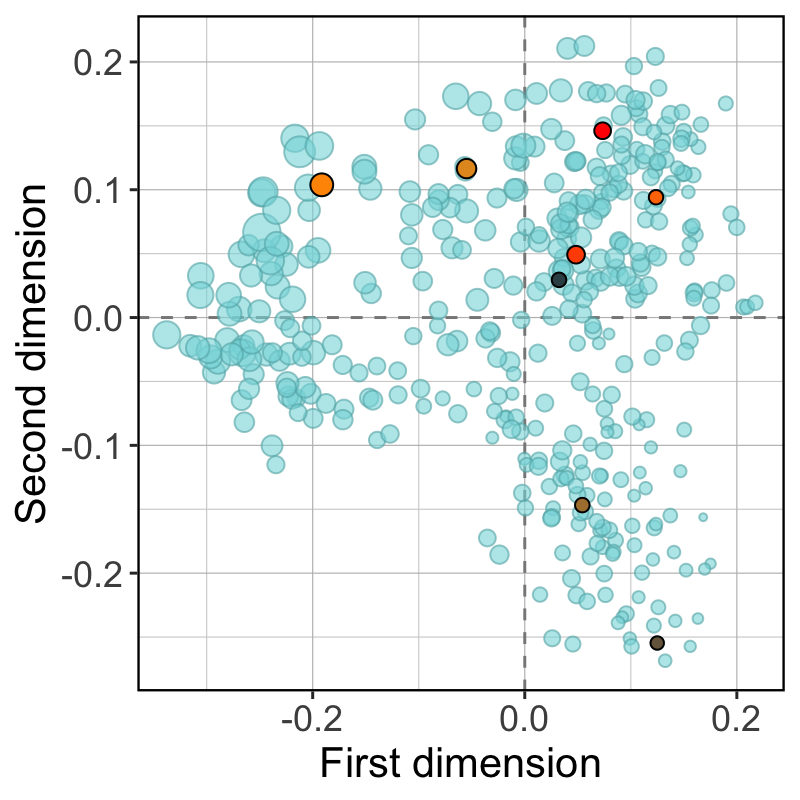

In [11]:
%%R -i df_volpk -i prot_name -w 4. -h 4. --units in -r 200

source('../../R_scripts/plot_cMDS.R')
prot_name <- prot_name

p <- plot_cMDS(df_volpk)

# Save the picture
space <- 'povme'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4., height= 4.) 
print(p)

## Swarplot with the AUC-ROC values per conformation
- The following plot show the distribution of the protein conformations regarding its AUC-ROC value computed from their individual docking results.

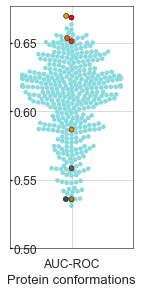

In [12]:
import matplotlib
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

top_confs = 8

# Define the colormap
cmap = LinearSegmentedColormap.from_list(
    name ='test', 
    colors = ["red", "orange", "#374E55"],
    N = top_confs
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale = 1.1, style = 'whitegrid')

# Filter the 
df_ = df_prot.copy()
# Get the top 16
df_['top_mask'] = [2 if i <= top_confs else 
                   1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']]\
                    .melt(id_vars=('top_mask', 
                                   'rfe_ranking'))

fig, ax = plt.subplots(figsize=(2.2, 4.45))
# Blue dots (all conformations)
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_, 
              size = 4.6,
              ax = ax,
              color = '#87DADE')
# Plot the top RFE 16 conformations
df_top = df_.query('top_mask == 2') 
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_top, 
              size = 5,
              ax  = ax,
              hue ='rfe_ranking',
              edgecolor = 'black', 
              linewidth = 0.5,
              palette = 'mycolormap')
# Axis and labels
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length = 2, color = 'black', axis = 'y')
ax.grid(True, linewidth = 0.7)
ax.tick_params(axis="y",direction="in", pad=-27)
ax.set(xlabel = 'Protein conformations', ylabel = '')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.savefig(f'{prot_name}_swarm_auc.pdf')

# Save the picture
plt.show()

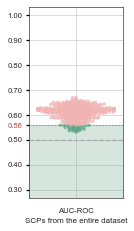

In [100]:
top_confs = 8

# Define the colormap
cmap = LinearSegmentedColormap.from_list(
    name ='test', 
    colors = ["red", "orange", "#374E55"],
    N = top_confs
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale = 0.7, style = 'whitegrid')

# Filter the 
df_ = df_prot.copy()
# Get the top 16
df_['top_mask'] = [2 if i <= top_confs else 
                   1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']]\
                    .melt(id_vars=('top_mask', 
                                   'rfe_ranking'))
# Get the AUC-ROC of the 32 lowest conformation
auc_worst_32 = df_['value'].nsmallest(32).max()
df_['worst_32'] = df_['value'] <= auc_worst_32

fig, ax = plt.subplots(figsize=(1.7, 3.52))
# Blue dots (all conformations)
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_, 
              size = 3.6,
              ax = ax,
              alpha = 0.7,
              hue = 'worst_32',
              palette = ['#F0B3B2', '#5CA586'])
# Axis and labels
ax.set_yticks(list(np.arange(0.3, 1.1, .1)) + [auc_worst_32])
ax.get_yticklabels()[-1].set_color("#B24745")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
plt.axhline(y=0.5, color='darkgrey', linewidth = 1.2, linestyle = '--')
plt.axhline(y=auc_worst_32, color='#79AF97', 
            linestyle=':', linewidth = 1.2)
ax.fill_between([-1,1], [0], [auc_worst_32], color='#79AF97', alpha = 0.3 )
ax.tick_params(length = 3, color = 'black', axis = 'y')
ax.grid(True, linewidth = 0.7)
# ax.tick_params(axis="y",direction="in", pad=-27)
ax.set_xlabel('SCPs from the entire dataset', fontsize = 8)
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.ylim(0.265, 1.033)
plt.savefig(f'{prot_name}_swarm_auc.pdf')
# Save the picture
plt.show()

## MDS using Secondary structure - Pisani (2016) residues.
- The following projection was computed from the pairwise RMSD matrix of the C$\alpha$ of the residues defined by Pisani (2016).

In [12]:
df_secRMSD = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]
df_secRMSD = df_secRMSD.rename({'secres_x': 'x', 'secres_y': 'y'}, axis = 1)

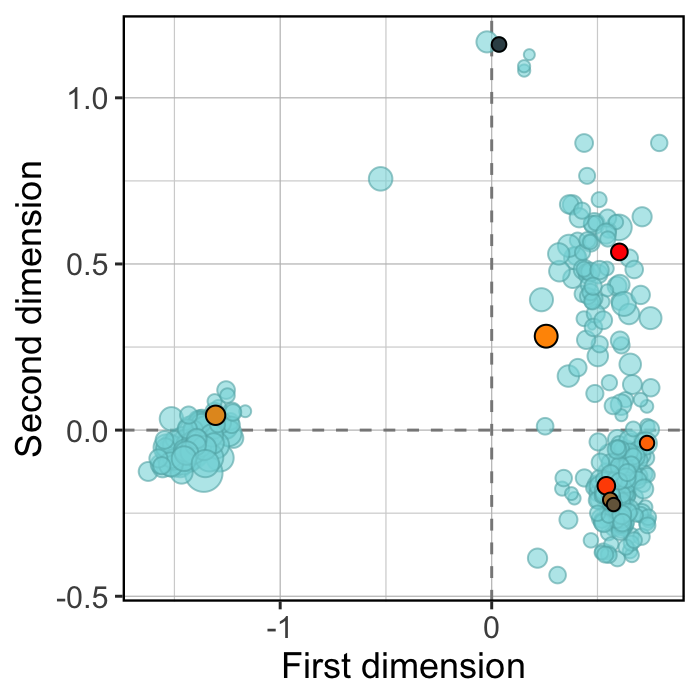

In [31]:
%%R -i df_secRMSD -w 3.5 -h 3.5 --units in -r 200

p <- plot_cMDS(df_secRMSD)

# Save the picture
space <- 'secRMSD'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4.0, height= 4.0) 
print(p)

## MDS using pocket residues

In [14]:
df_pkRMSD = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]
df_pkRMSD = df_pkRMSD.rename({'pkt_x': 'x', 'pkt_y': 'y'}, axis = 1)

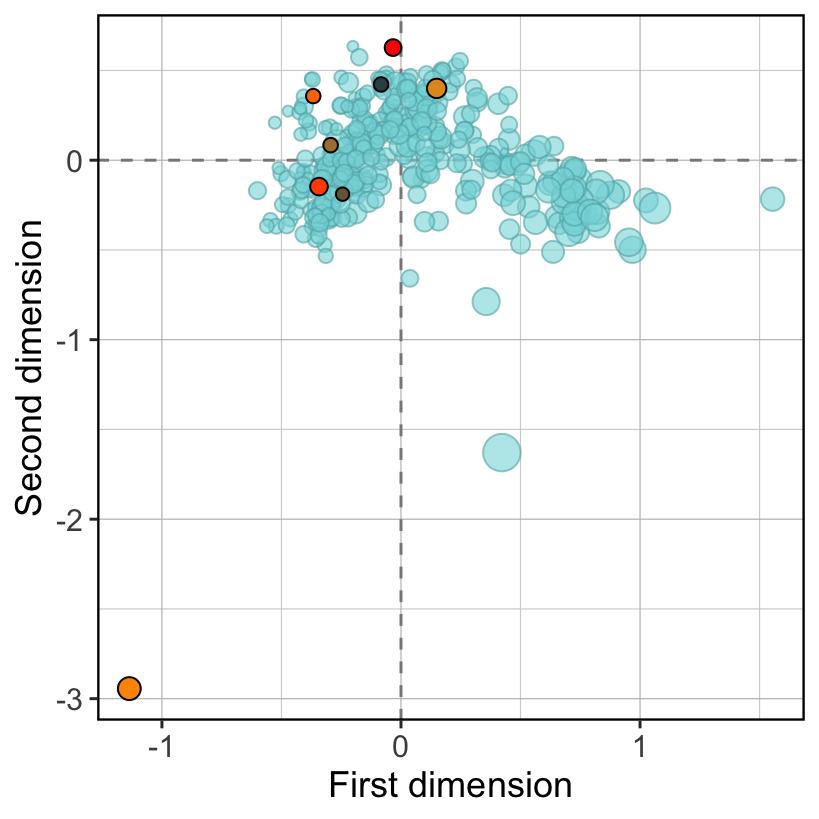

In [15]:
%%R -i df_pkRMSD -w 4.1 -h 4.1 --units in -r 200

p <- plot_cMDS(df_pkRMSD)

# Save the picture
space <- 'pkRMSD'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4.0, height= 4.0) 
print(p)